In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Setup logging with some hacks to work in the notebook.
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from math import sqrt
from skimage.transform import resize

import sys; sys.path.append('../')
from src.models.unet_jocic import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms

logger.info('Done')

INFO:root:Done


Using TensorFlow backend.


In [2]:
# Load data.
model = UNet()
model.config['data_path'] = '../data'
model.load_data()
logger.info('Done')

INFO:load_data:Reading images from ../data.
INFO:load_data:Combining images and masks into montages.
INFO:load_data:Combining validation images and masks into montages
INFO:root:Done


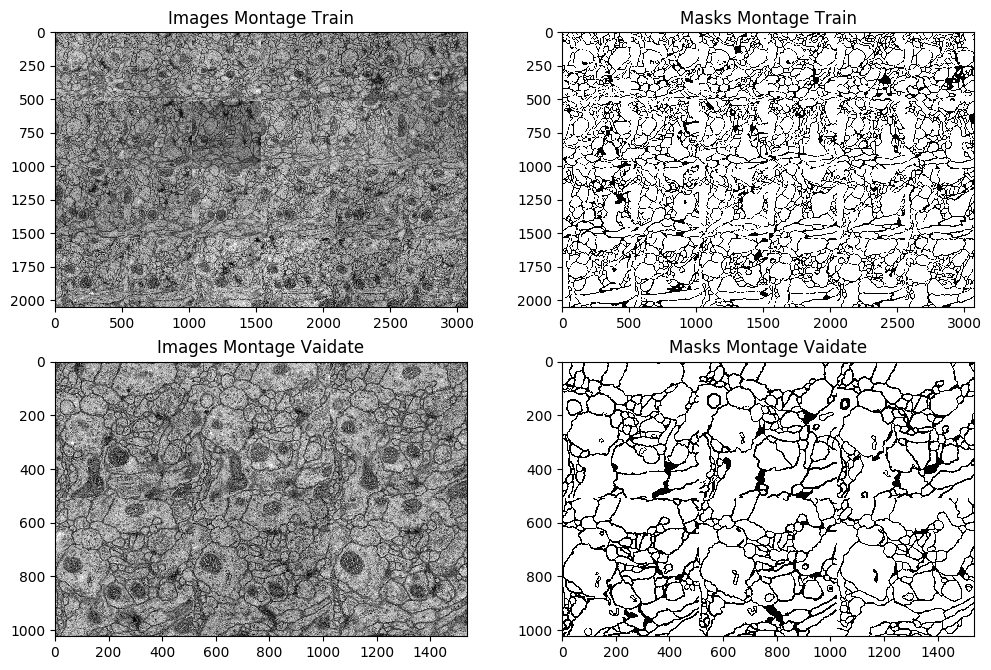

In [3]:
# Plot image and mask montages.
fig,_ = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
fig.axes[0].set_title('Images Montage Train')
fig.axes[0].imshow(model.imgs_montage_trn, cmap='gray')
fig.axes[1].set_title('Masks Montage Train')
fig.axes[1].imshow(model.msks_montage_trn, cmap='gray')
fig.axes[2].set_title('Images Montage Vaidate')
fig.axes[2].imshow(model.imgs_montage_val, cmap='gray')
fig.axes[3].set_title('Masks Montage Vaidate')
fig.axes[3].imshow(model.msks_montage_val, cmap='gray')
plt.show()

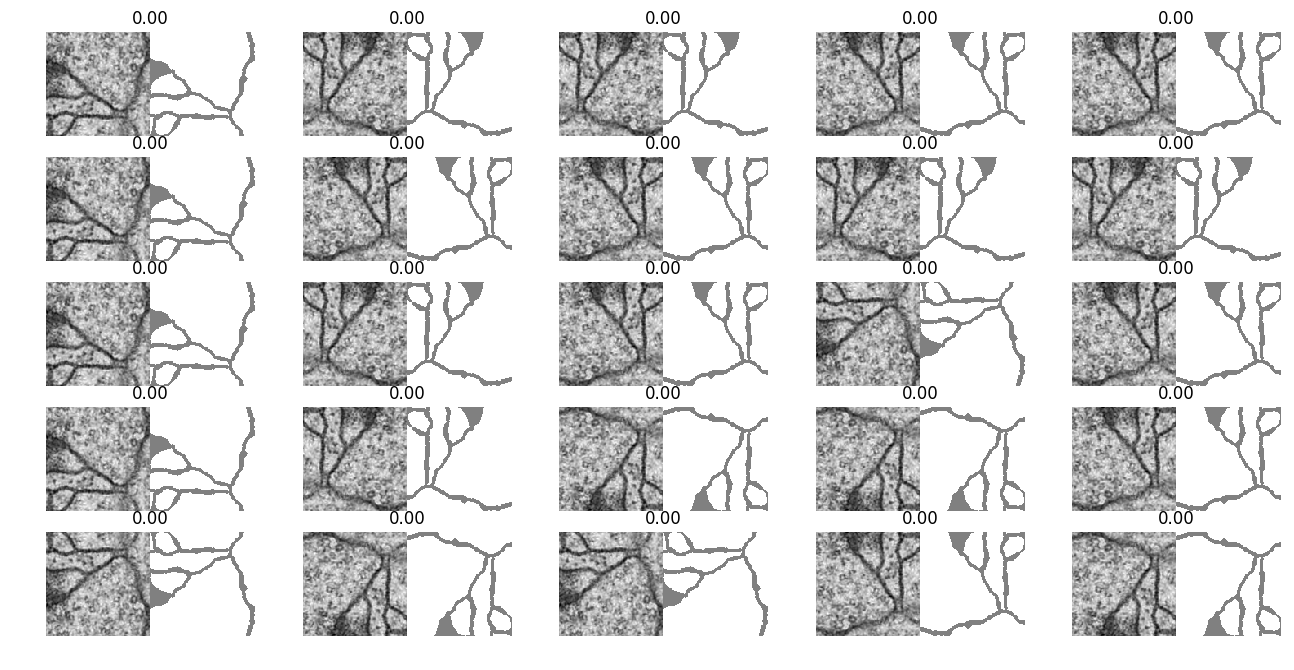

In [6]:
# Plot random transformations.
np.random.seed(model.config['seed'])
data_gen = model.batch_gen(imgs=model.imgs_montage_trn, msks=model.msks_montage_trn, batch_size=1)
img_batch, msk_batch = next(data_gen)
img = img_batch[0].reshape(128,128)
msk = msk_batch[0].reshape(128,128)

fig, _ = plt.subplots(nrows=5, ncols=5, figsize=(16,8))

for ax in fig.axes:
    [img_t, msk_t] = random_transforms([img, msk])
    ax.axis('off')
    ax.imshow(np.hstack([img_t,msk_t]), cmap='gray')
    msk_diff = abs(np.sum(msk) - np.sum(msk_t))
    ax.set_title('%.2lf' % (msk_diff))
    
plt.show()

In [7]:
# Load network.
gpu_selection(visible_devices="2")
model.compile()
model.net.load_weights('../checkpoints/unet_jocic_128.net')
logger.info('Done')

INFO:root:Done


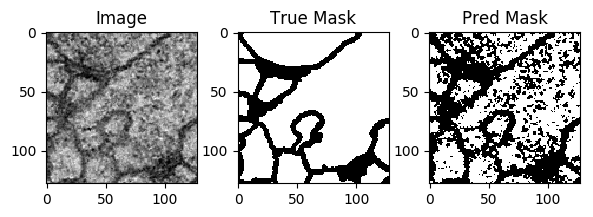

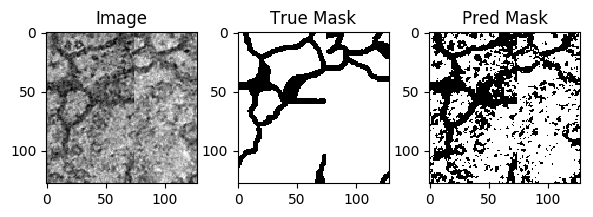

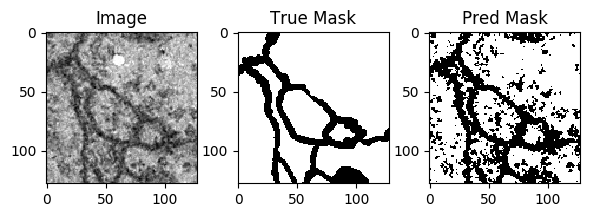

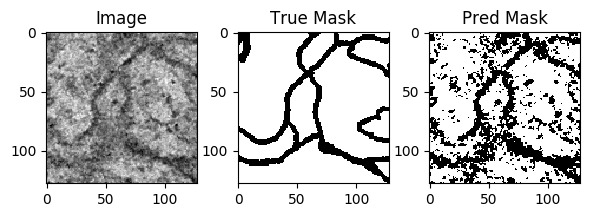

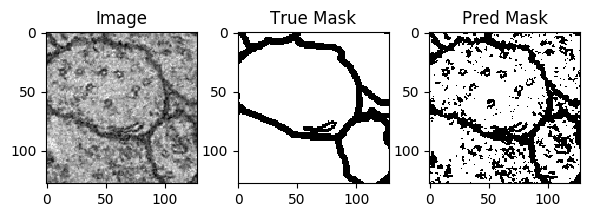

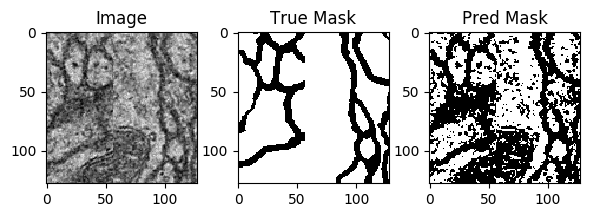

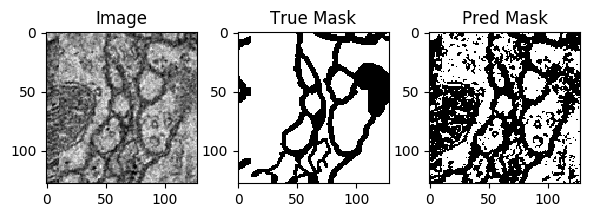

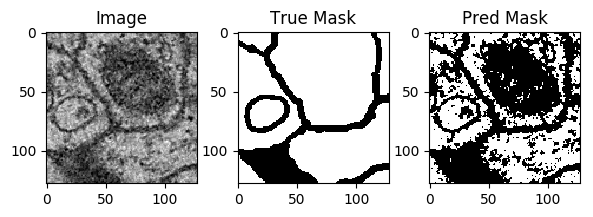

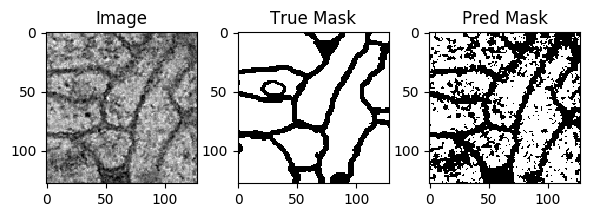

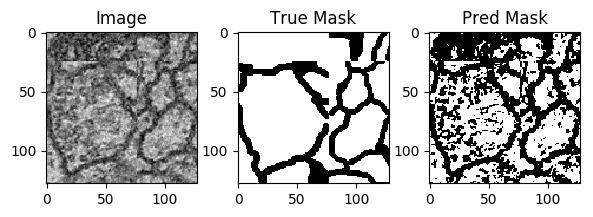

In [8]:
# Plot predictions.
data_gen = model.batch_gen(imgs=model.imgs_montage_val, msks=model.msks_montage_val, batch_size=10)
img_batch, msk_batch = next(data_gen)
prd_batch = model.net.predict(img_batch)

for img, msk, prd in zip(img_batch, msk_batch, prd_batch):
    r = c = int(sqrt(img.size))
    prd = prd.round()
    fig,_ = plt.subplots(nrows=1, ncols=3, figsize=(7,2))
    fig.axes[0].set_title('Image')
    fig.axes[0].imshow(img.reshape(r,c), cmap='gray')
    fig.axes[1].set_title('True Mask')
    fig.axes[1].imshow(msk.reshape(r,c), cmap='gray')
    fig.axes[2].set_title('Pred Mask')
    fig.axes[2].imshow(prd.reshape(r,c), cmap='gray')
    plt.show()

In [22]:
# # Plot submission images and predictions.
# imgs_test = tiff.imread('../data/test-volume.tif')
# msks_test = tiff.imread('../checkpoints/unet_jocic_128.submission.tif')

# for img, msk in zip(imgs_test, msks_test):
#     fig, _ = plt.subplots(nrows=1, ncols=2)
#     fig.axes[0].imshow(img, cmap='gray')
#     fig.axes[0].set_title('Test Image')
#     fig.axes[1].imshow(msk.round(), cmap='gray')
#     fig.axes[1].set_title('Prediction')
#     plt.show()